# Data analysis of GO CHI2 at Tref = 50

In [2]:
# Import Python packages

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import axes
import nglview as nv
import mdtraj as md

In [4]:
# Import Python molecular dynamics tools

In [5]:
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align, pca
from MDAnalysis.analysis import dihedrals
from MDAnalysis.analysis import contacts
from MDAnalysis.analysis import helix_analysis as hel
from MDAnalysis.tests.datafiles import PDB, GRO, XTC

In [6]:
# Import data (protein only)
datadir = os.getcwd()
datadir

'/Users/teresa/Desktop/Definitive_PPP/GO'

In [28]:
# CHI1
datadir = os.getcwd()

gro = datadir+'/smog_chi2_50/chi2.28504.pdb.gro'
xtc = datadir+'/smog_chi2_50/traj_comp_centered.xtc'
tpr = datadir+'/smog_chi2_50/run.tpr'


## Load trajectory

In [29]:
u1 = mda.Universe(gro, xtc, in_memory= True)

In [30]:
# Print figure
# domain_view.render_image()
#domain_view.download_image(filename='my_image.png', factor=4, trim=True)
domain_view = nv.show_mdanalysis(u1) 
domain_view.color_by('chainID') 
domain_view
print("Trajectory length="+str(len(u1.trajectory))+" frames.")

Trajectory length=4001 frames.


In [10]:
# Equivalently can load trajectory as
# traj = md.load("step5_production_center.xtc", top="chi2_proa.cg.pdb")
# view = nv.show_mdtraj(traj)
# view

## Radius of gyration

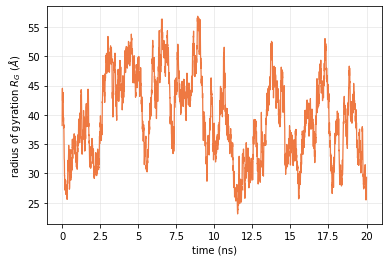

In [38]:
Rgyr = []

protein = u1.select_atoms("protein")

for ts in u1.trajectory:
    Rgyr.append((u1.trajectory.time, protein.radius_of_gyration())) 
Rgyr = np.array(Rgyr)

# plot
ax = plt.subplot(111)
ax.plot(Rgyr[:,0], Rgyr[:,1], color = '#EE7942', lw=1.25) 

scale_x = 1e3
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
ax.xaxis.set_major_formatter(ticks)

ax.set_xlabel("time (ns)")
ax.set_ylabel(r"radius of gyration $R_G$ ($\AA$)") 
ax.grid(color = '#DCDCDC', lw = 0.5)
plt.draw()

## RMSD CHI1

In [39]:
R = rms.RMSD(u1, # universe to align
             u1, # reference universe 
             select = 'protein', # group to superimpose and calculate the RMSD
             ref_frame = 0) # frame index for reference

R.run()

Text(0, 0.5, 'RMSD ($\\AA$)')

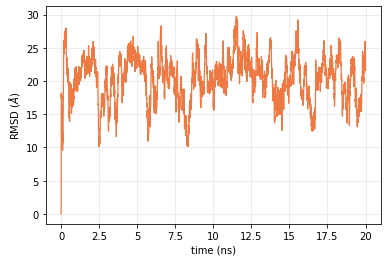

In [40]:
rmsd = R.results.rmsd.T   # transpose makes it easier for plotting
time = rmsd[1]
#fig = plt.figure(figsize=(4,4))
ax = plt.subplot(111)
ax.plot(time, rmsd[2], color = '#EE7942', lw=1.25 ) #,  label="T = 50"
#ax.legend(loc="best")

scale_x = 1e3
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
ax.xaxis.set_major_formatter(ticks)

ax.grid(color = '#DCDCDC', lw = 0.5)

ax.set_xlabel("time (ns)")
ax.set_ylabel(r"RMSD ($\AA$)")
#fig.savefig("rmsd_all_CORE_LID_NMP_ref1AKE.pdf")

## Alignment of the trajectory to the first frame

In [41]:
mobile = u1
ref = u1

mobile.trajectory[-1] #set mobile trajectory to last frame
ref.trajectory[0] # set reference trajectory to first frame

mobile_sel = mobile.select_atoms('protein') 
ref_sel = ref.select_atoms('protein')

In [42]:
aligner = align.AlignTraj(mobile, ref,
                          select='all',
                          in_memory=True).run()

## RMSF 

In [43]:
RR = rms.RMSF(mobile_sel).run()

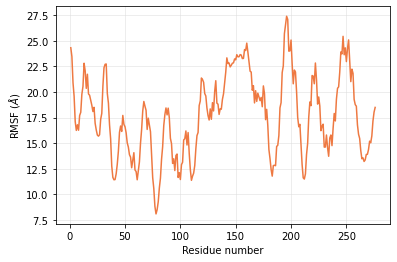

In [44]:
plt.plot(mobile_sel.resids, RR.results.rmsf, color = '#EE7942', lw=1.5) # label = "T = 50"
plt.xlabel('Residue number')
plt.ylabel('RMSF ($\AA$)')

plt.grid(color = '#DCDCDC', lw = 0.5)

#plt.legend()

## Visualising RMSF as B-factors

In [46]:
mobile.add_TopologyAttr('tempfactors')
for residue, r_value in zip(mobile_sel.residues, RR.results.rmsf):
    residue.atoms.tempfactors = r_value

In [27]:
view = nv.show_mdanalysis(u1)
view.update_representation(color_scheme='bfactor')
view

NGLWidget(max_frame=4000)